In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm.autonotebook import tqdm

plt.rcParams["pdf.fonttype"]=42

class ImageAnnotatorConfig:
    def __init__(self, point_color='royalblue', text_color='royalblue', scalebar_color='k',
                 scalebar_text_color='k', point_size=5, text_offset_x=0, text_offset_y=-30,
                 font_size=7, font_thickness=2, scalebar_xy=(100, 900), scalebar_thickness=2, suffix="[-_.]",meta_extension=".txt",Sample_ID='SAMPLE',xposition='X_POS', yposition='Y_POS'):
        self.point_color = point_color
        self.text_color = text_color
        self.scalebar_color = scalebar_color
        self.scalebar_text_color = scalebar_text_color
        self.point_size = point_size
        self.text_offset_x = text_offset_x
        self.text_offset_y = text_offset_y
        self.font_size = font_size
        self.font_thickness = font_thickness
        self.scalebar_xy = scalebar_xy
        self.scalebar_thickness = scalebar_thickness
        self.suffix = suffix
        self.meta_extension=meta_extension
        self.Sample_ID=Sample_ID
        self.xposition=xposition
        self.yposition=yposition

def named_color_to_rgb(name):
    return mcolors.to_rgba(name)[:3]

def annotate_image(image_path, data_path, data_table_name, sheet_name, image_file_name, config=ImageAnnotatorConfig(), plot_result=True,save_fig='png',show_bbox=True):
    image = plt.imread(os.path.join(image_path, image_file_name))
    df = pd.read_excel(os.path.join(data_path, data_table_name), sheet_name=sheet_name)

    imagefilename = image_file_name
    try:
        with open(os.path.join(image_path, imagefilename.split('.')[0] + config.meta_extension)) as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith("$CM_FULL_SIZE"):
                    parts = line.split()
                    new_width = int(parts[1])
                    new_height = int(parts[2])
                if line.startswith("$CM_STAGE_POS"):
                    parts = line.split()
                    stage_x = float(parts[1])
                    stage_y = float(parts[2])
                if line.startswith("$$SM_MICRON_BAR"):
                    parts = line.split()
                    pixels = float(parts[1])
                if line.startswith("$$SM_MICRON_MARKER"):
                    parts = line.split()
                    microns4pixels = float(parts[1].split("u")[0])

        scale_px_per_micron = pixels / microns4pixels
        Sample_ID=config.Sample_ID
        xpos=config.xposition
        ypos=config.yposition
        subset_df = df[[Sample_ID, xpos, ypos]].copy()
        subset_df['stage_x'] = stage_x
        subset_df['stage_y'] = stage_y
        subset_df['dx (\u03BCm)'] = 1000 * (stage_x - subset_df[xpos])
        subset_df['dy (\u03BCm)'] = 1000 * (stage_y - subset_df[ypos])
        suffix = config.suffix
        data2plot = subset_df[subset_df[Sample_ID].str.contains(imagefilename.split('.')[0] + suffix)].reset_index()

        height, width, _ = image.shape

        if height != new_height:
            left = 0
            top = 0
            right = new_width
            bottom = new_height
            cropped_image = image[top:bottom, left:right]
        else:
            cropped_image = image.copy()

        height, width, _ = cropped_image.shape

        center_x = width // 2
        center_y = height // 2

        dx = data2plot['dx (\u03BCm)'] * scale_px_per_micron
        dy = data2plot['dy (\u03BCm)'] * scale_px_per_micron

        x = center_x + dx
        y = center_y - dy

        text_col = data2plot[Sample_ID]

        point_color = config.point_color
        text_color = config.text_color
        scalebar_color = config.scalebar_color
        scalebar_text_color = config.scalebar_text_color
        point_size = config.point_size
        text_offset_x = config.text_offset_x
        text_offset_y = config.text_offset_y
        font_size = config.font_size
        font_thickness = config.font_thickness
        scalebar_xy = config.scalebar_xy
        scalebar_thickness = config.scalebar_thickness

        if isinstance(point_color, str):
            point_color = named_color_to_rgb(point_color)
        if isinstance(text_color, str):
            text_color = named_color_to_rgb(text_color)
        if isinstance(scalebar_color, str):
            scalebar_color = named_color_to_rgb(scalebar_color)
        if isinstance(scalebar_text_color, str):
            scalebar_text_color = named_color_to_rgb(scalebar_text_color)

        fig, ax = plt.subplots()
        ax.imshow(cropped_image)

        for i in range(len(x)):
            ax.scatter(x[i], y[i], s=point_size, color=point_color)

            text = ax.text(
                x[i] + text_offset_x,
                y[i] + text_offset_y,
                text_col[i],
                fontsize=font_size,
                color=text_color,
                fontweight='bold',
                horizontalalignment='center'
            )
            if show_bbox==True:
                text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))

        ax.plot(
            [scalebar_xy[0], scalebar_xy[0] + int(pixels * scale_px_per_micron)],
            [scalebar_xy[1], scalebar_xy[1]],
            color=scalebar_color,
            linewidth=scalebar_thickness
        )

        scalebar_text = str(int(microns4pixels)) + " \u00B5m"
        sctext=ax.text(
            scalebar_xy[0] + (int(pixels * scale_px_per_micron) / 2),
            scalebar_xy[1] - 20,
            scalebar_text,
            fontsize=font_size,
            color=scalebar_text_color,
            fontweight='bold',
            horizontalalignment='center'
        )
        if show_bbox==True:
            sctext.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))


        labeled_image_folder = os.path.join(image_path, 'labeled_images')

        if not os.path.exists(labeled_image_folder):
            os.mkdir(labeled_image_folder)

        plt.axis('off')

        if save_fig=='pdf&tif':
            plt.savefig(os.path.join(labeled_image_folder, image_file_name.split('.')[0] + "_labeled.tif"), dpi=300,bbox_inches='tight', pad_inches=0)       
            plt.savefig(os.path.join(labeled_image_folder, image_file_name.split('.')[0] + "_labeled.pdf"), dpi=300,bbox_inches='tight', pad_inches=0)
            
        elif save_fig=='png':
            plt.savefig(os.path.join(labeled_image_folder, image_file_name.split('.')[0] + "_labeled.png"), dpi=300,bbox_inches='tight', pad_inches=0)       
            
        elif save_fig=='tif':
            plt.savefig(os.path.join(labeled_image_folder, image_file_name.split('.')[0] + "_labeled.tif"), dpi=300,bbox_inches='tight', pad_inches=0)       
            
        if save_fig=='pdf':   
            plt.savefig(os.path.join(labeled_image_folder, image_file_name.split('.')[0] + "_labeled.pdf"), dpi=300,bbox_inches='tight', pad_inches=0)
            
        if plot_result:
            plt.show()
        plt.close()
    except FileNotFoundError as e:
        print(e)


## Example for a single image

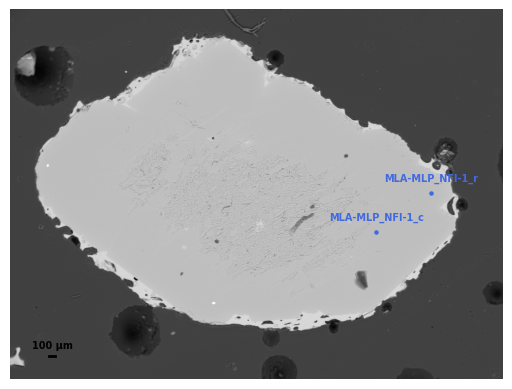

In [5]:
# Set these to appropriate paths and names for your data

# Set these to appropriate paths and names for your data
image_path =r"C:\Users\charl\Documents\Python dev\Probe_TIF\Image_examples"  # Path where images and metadata are stored
data_path = r"C:\Users\charl\Documents\Python dev\Probe_TIF\Data_Folder" # Path where your data excel file is stored (Output from Probe for EPMA)
data_table = 'Data_example.xlsx' # This is the name of your datatable (excel file)
sheet_name = 'Sheet1' # Sheet name where the data is

image_file = "MLA-MLP_NFI-1.tif" #Name of the image you want to process

# Next is the configuration setup, it controls dot size and color, text size, color and positioning, white box behind text or not, scale bar size and color, etc. 
# You can run it with the defaults, or you can change as you want. 
# suffix specifies what suffix is at the end of the name of the files,

# IMPORTANT_NOTE: I highly recommend adding a suffix to your "SAMPLE" column in the data excel file, here the default is -, _ or . 
# Just add _ , - or . at the end of all your sample names in excel

config=ImageAnnotatorConfig() # This will use the default configuration

# If you want to change anything (color, text size, etc), uncomment the following "config=..." and change it as desired 
# (i.e., point_color='k' will plot the point in black instead of royal blue):

# config = ImageAnnotatorConfig(
#     point_color='royalblue',
#     text_color='royalblue',
#     scalebar_color='k',
#     scalebar_text_color='k',
#     point_size=5,
#     text_offset_x=0,
#     text_offset_y=-30,
#     font_size=7,
#     font_thickness=2,
#     scalebar_xy=(100, 900),
#     scalebar_thickness=2,
#     suffix="[-_.]",
#     meta_extension=".txt",
#     Sample_ID='SAMPLE',
#     xposition='X_POS', 
#     yposition='Y_POS'
# )

annotated_image = annotate_image(image_path, data_path, data_table, sheet_name, image_file, config,plot_result=True,save_fig='pdf',show_bbox=False)

## Now let's loop through all your image files in the folder 

In [6]:
# Set these to appropriate paths and names for your data
image_path =r"C:\Users\charl\Documents\Python dev\Probe_TIF\Image_examples"  # Path where images and metadata are stored
data_path = r"C:\Users\charl\Documents\Python dev\Probe_TIF\Data_Folder" # Path where your data excel file is stored (Output from Probe for EPMA)
data_table = 'Data_example.xlsx' # This is the name of your datatable (excel file)
sheet_name = 'Sheet1' # Sheet name where the data is

image_extension = '.tif' # Set the image extension

# Now setup the configuration
config=ImageAnnotatorConfig() # This will use the default configuration, as before, you can change these as you want. 


# This extracts the list of image files in the folder (no need to edit)
image_list = [file for file in os.listdir(image_path) if file.endswith(image_extension)]
print(image_list)

# This runs the loop
for file in tqdm(image_list, desc="Processing"):
    annotated_image = annotate_image(image_path, data_path, data_table, sheet_name, file, config, plot_result=False,save_fig='pdf',show_bbox=False)

['MLA-MLP_NFI-1.tif', 'MLA-MLP_NFI-10.tif', 'MLA-MLP_NFI-11.tif', 'MLA-MLP_NFI-21.tif', 'MLA-MLP_NFI-5.tif', 'MLA-MP2_NFI-16.tif', 'MLA-MP2_NFI-17.tif']


Processing:   0%|          | 0/7 [00:00<?, ?it/s]